In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt

os.chdir('/home/bruno/datacloud')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (7.5, 5)

In [3]:
from theory.core import Pipe, Rock, TheoreticalWavelet, MultipleWavelets

In [4]:
pipe = Pipe()

In [5]:
import pint
import numpy as np

In [6]:
from plotly import tools

In [67]:
DEFAULT_INPUT_UNITS = {
    "length": 'm',
    "outer_diameter": 'in',
    "inner_diameter": 'in',
    "weight": 'kg',
    "alpha": 'm/s',
    "beta": 'm/s',
    "rho": 'kg/m^3',
}

DEFAULT_OUTPUT_UNITS = {
    "length": 'm',
    "outer_diameter": 'm',
    "inner_diameter": 'm',
    "weight": 'kg',
    "alpha": 'm/s',
    "beta": 'm/s',
    "rho": 'kg/m^3',
}

ureg = pint.UnitRegistry()

class DrillComponent(object):
    '''
    A base class to be used as a component of the drill.
    '''
    def __init__(self, 
                 name=None,
                 length=None, 
                 outer_diameter=None,
                 inner_diameter=None, 
                 weight=None, 
                 rho=None,
                 alpha=None,
                 beta=None,
                 product_id=None,
                 catalogue_no=None,
                 input_units=DEFAULT_INPUT_UNITS,
                 output_units=DEFAULT_OUTPUT_UNITS,
                ):
        
        self.name = name
        self.component = component # axial or tangential
        
        # These are all physical or geometrical properties of the component wraped by pint to make it work with
        # multiple units.
        self._length = length * ureg(input_units['length'], force_ndarray=True).to('m') if length else None
        self._outer_diameter = outer_diameter * ureg(input_units['outer_diameter'], force_ndarray=True).to('m') if outer_diameter else None
        self._inner_diameter = inner_diameter * ureg(input_units['inner_diameter'], force_ndarray=True).to('m') if inner_diameter else None
        self._weight = weight * ureg(input_units['weight'], force_ndarray=True).to('kg') if weight else None
        self._rho = rho * ureg(input_units['rho'], force_ndarray=True).to('kg/m^3') if rho else None
        self._alpha = alpha * ureg(input_units['alpha'], force_ndarray=True).to('m/s') if alpha else None
        self._beta = beta * ureg(input_units['beta'], force_ndarray=True).to('m/s') if beta else None
        
        # Dictionaries holding units
        self.input_units = input_units
        self.output_units = output_units
        
        # Product information
        self.product_id = product_id
        self.catalogue_no = catalogue_no
        
        self.A1 = self.effective_area
        self.Z1 = self.impedance
        
    def set_attribute_unit(self, attribute, unit):
        '''
        Set new unit for the output dict.
        '''
        self.output_units[attribute] = unit
    
    @property
    def length(self):
        '''
        Length of the component.
        '''
        if self._length:
            return self._length.to(self.output_units['length'])
        else:
            return np.nan
        
    @property
    def outer_diameter(self):
        '''
        Outer diameter of the component.
        '''
        if self._outer_diameter:
            return self._outer_diameter.to(self.output_units['outer_diameter'])
        else:
            return np.nan
        
    @property
    def od(self):
        '''
        Outer diameter of the component.
        '''
        return self.outer_diameter
        
    @property
    def inner_diameter(self):
        '''
        Inner diameter of the component.
        '''
        if self._inner_diameter:
            return self._inner_diameter.to(self.output_units['inner_diameter'])
        else:
            if ~np.isnan(self.outer_diameter) & ~np.isnan(self.length) & ~np.isnan(self.weight) & ~np.isnan(self.rho):
                return np.sqrt(((self.od**2)-((4*self.weight)/((self.density*np.pi*self.length))))).to(self.output_units['inner_diameter'])
            pass
    
    def effective_area(self, component='axial'):                                                                  
        """                                                                        
        Cross section area. (Old A1 - Effective drill stem area for axial.)
        """      
        if component == 'axial':
            return np.pi * (((self.outer_diameter / 2) ** 2) - ((self.inner_diameter / 2) ** 2))
        if component == 'tangential':
            return np.pi * (((self.outer_diameter / 2) ** 2) + ((self.inner_diameter / 2) ** 2))
        
    @property
    def weight(self):
        '''
        Weight of the component.
        '''
        if self._weight:
            return self._weight.to(self.output_units['weight'])
        else:
            return np.nan
        
    @property
    def alpha(self):
        '''
        Compressional velocity of the component.
        '''
        if self._alpha:
            return self._alpha.to(self.output_units['alpha'])
        else:
            return np.nan
    
    @property
    def beta(self):
        '''
        Shear velocity of the component.
        '''
        if self._beta:
            return self._beta.to(self.output_units['beta'])
        else:
            return np.nan
    
    @property
    def rho(self):
        '''
        Density of the component.
        '''
        if self._rho:
            return self._rho.to(self.output_units['rho'])
        else:
            return np.nan
        
    @property
    def density(self):
        '''
        Density of the component.
        '''
        return self.rho
    
                                                                                   
    @property                                                                      
    def Ab(self):                                                                  
        """                                                                        
        Area of the bit contacting rock.                                           
        """                                                                        
        return np.pi * (self.Rb ** 2)
                                                                                   
    def impedance(self, component='axial'):                                                                  
        """                                                                        
        Steel impedance. (Old Z1)                                                        
        """                                                                        
        if component == 'axial':                                              
            return self.Ab * self.rho * self.alpha * (3/4)                         
        if component == 'tangential':                                         
            return self.Ab * self.rho * self.beta 

        
    def delay(self, component='axial'):
        '''
        '''
        if component == 'axial':                                              
            return 2 * self.length / self.alpha
        if component == 'tangential':                                              
            return 2 * self.length / self.beta
    
    def __repr__(self):
        return '<Drill component: {} - OD: {}, ID: {}, Length: {}>'.format(
            self.name, 
            str((np.round(self.od, 2))),
            str((np.round(self.inner_diameter, 2))),
            str((np.round(self.length, 2))),
        )

In [68]:
import pint

In [419]:
for component in ['axial', 'tangential']:
    bitsub = DrillComponent('bitsub',  length=51,  outer_diameter=7.625,  inner_diameter=2.77,  weight=2998,  
                            rho=7850, alpha=4875, beta=2368,
                    input_units={
                          'length': 'in', 
                          'outer_diameter': 'in', 
                          'inner_diameter': 'in', 
                          'weight': 'lbs', 
                          'alpha': 'm/s', 
                          'beta': 'm/s', 
                          'rho': 'kg/m^3'
                      })

    pipe = DrillComponent('pipe',  length=300,  outer_diameter=7.625,  inner_diameter=5.41,  weight=4210,  
                            rho=7850, alpha=4875, beta=2368,
                    input_units={
                          'length': 'in', 
                          'outer_diameter': 'in', 
                          'inner_diameter': 'in', 
                          'weight': 'lbs', 
                          'alpha': 'm/s', 
                          'beta': 'm/s', 
                          'rho': 'kg/m^3'
                      })

    RC = (np.asarray(bitsub.effective_area(component)) - np.asarray(pipe.effective_area(component))) / (np.asarray(bitsub.effective_area(component)) + np.asarray(pipe.effective_area(component)))
    print('RC for {}: {}'.format(component, RC))
    print('delay for bitsub {}: {}'.format(component, bitsub.delay(component).to('ms')))
    print('delay for pipe {}: {}'.format(component, pipe.delay(component).to('ms')))    
    print()

RC for axial: 0.2721846729749403
delay for bitsub axial: 0.5314461538461538 millisecond
delay for pipe axial: 3.126153846153846 millisecond

RC for tangential: -0.14094036603691706
delay for bitsub tangential: 1.0940878378378378 millisecond
delay for pipe tangential: 6.435810810810811 millisecond



/home/bruno/miniconda3/envs/dcpipe/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning:

The unit of the quantity is stripped.



In [420]:
class Drillstring(object):
    def __init__(self, drill_components, device_location=None):
        self.drill_components = drill_components
        self.deduplication()
        self.length = sum([component.length for component in drill_components])
        
        distance_from_top = 0* ureg('m')
        for component in self.drill_components:
            component.distance_from_top = distance_from_top
            distance_from_top += component.length    

    def deduplication(self):
        from collections import Counter
        counter_components = Counter([c.name for c in self.drill_components])
        duplicated_components = [k for k, v in counter_components.items() if v > 1]

        for duplicated_component in duplicated_components:
            counter = 1
            for i, component in enumerate(self.drill_components):
                if component.name == duplicated_component:
                    self.drill_components[i] = deepcopy(component)
                    component = self.drill_components[i]
                    component.name = component.name + ' #' + str(counter)
                    counter += 1
    
    def plot(self):
        palette = sns.color_palette("pastel", len(self.drill_components))
        fig, ax = plt.subplots(1,1, figsize=(15,5))
        for dc, color in zip(self.drill_components, palette):
            width=dc.length.magnitude
            xmin = dc.distance_from_top.magnitude
            xmax = xmin + width
            patch = plt.Rectangle((xmin, (-dc.outer_diameter/2).magnitude), 
                                  width=dc.length.magnitude, 
                                  height=dc.outer_diameter.magnitude, color=color, label=dc.name)
            ax.add_patch(patch)

            ax.hlines([dc.inner_diameter.magnitude/2, -dc.inner_diameter.magnitude/2], xmin, xmax, linestyles='dashed')

        ax.set_xlim(-1, ds.length.magnitude+1)
        ax.set_ylim(-max([c.outer_diameter for c in self.drill_components]).magnitude*3, max([c.outer_diameter for c in self.drill_components]).magnitude*3)
        ax.set_xlabel('Length ({})'.format(dc.length.units))
        ax.set_ylabel('XSection ({})'.format(dc.od.units))
        ax.legend()

In [421]:
from copy import deepcopy

In [422]:
ds = Drillstring([pipe1, pipe2, bitsub])

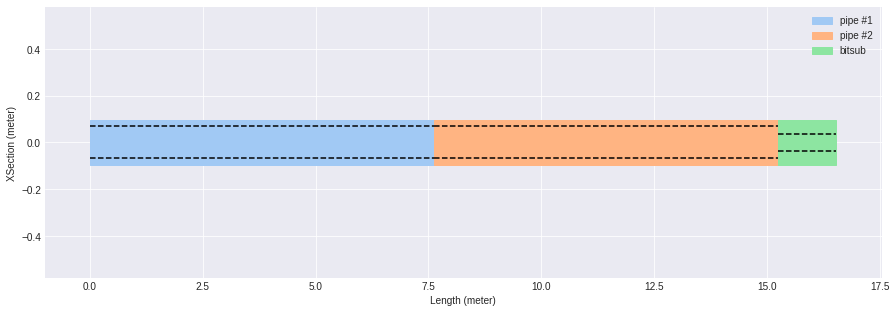

In [423]:
ds.plot()

In [133]:
class WaveTrajectory(object):
    def __init__(self, 
                 wave_type='primary',
                 initial_time=0, 
                 start_position=0, 
                 end_time=10, 
                 end_position=10, 
                 sensor_position=8,
                 velocity=1,
                 order=0,
                ):
        self.start_position = start_position
        self.initial_time = initial_time
        self.end_position = end_position
        self.velocity = velocity
        self.wave_type = wave_type
        self.sensor_position = sensor_position
        self.order = order
        
        self.traveling_up = (self.end_position > self.start_position)
        self.traveling_down = not(self.traveling_up)
        
        self.displacement = self.end_position - self.start_position
        
    def current_position(self, time=5):
        return self.velocity * time
    
    @property
    def end_time(self):
        return self.displacement / self.velocity
    
    @property
    def displacement_to_sensor(self):
        return self.sensor_position - self.start_position
    
    @property
    def hit_sensor(self):
        if (self.end_position > self.sensor_position) & (self.start) & (self.traveling_up):
            return True
        elif (self.end_position < self.sensor_position) & (self.start) & (self.traveling_down):
            return True
        else:
            return False
        
    @property
    def time_it_hits_sensor(self):
        if self.hit_sensor:
            return self.velocity * self.displacement_to_sensor + self.initial_time
        else:
            return None
        
    

In [134]:
wt = WaveTrajectory(velocity=.5, initial_time=10, start_position=0, sensor_position=-6)

In [135]:
wt.end_time

20.0

In [131]:
wt.hit_sensor

True

In [60]:
wt.current_position(1454.31535)

727.157675

In [61]:
wt.time_it_hits_sensor

8.0